# 36. HNSWトップK件のハミング距離分布分析

## 背景と仮説

実験35で、5000件規模でもOverlap(8,2)で外部R@10=94.3%を達成できることがわかった。
しかし、データセット規模によってセグメントOR検索の効果が異なる可能性がある。

## 仮説

**データセット規模によって、類似ドキュメント間のハミング距離分布が異なるのではないか？**

- 40万件: 類似ドキュメントが多く、上位K件のハミング距離が小さい
- 5000件: 類似ドキュメントが少なく、上位K件のハミング距離が大きい

もし5000件でハミング距離が大きければ、8bitセグメントの完全一致が困難になり、
Overlap(8,4)のバケットOR検索でもヒットしにくくなる。

## 検証方法

1. 40万件と5000件のデータセットを用意（DuckDBのHNSW拡張を使用）
2. HNSWで上位100件、500件、2000件を取得
3. クエリと各Top-K件のハミング距離分布を比較
4. 内部クエリ（データセット内）と外部クエリ（キーワード）の両方で検証
5. Overlap(8,4)セグメント一致との関連を分析

In [110]:
import sys
sys.path.insert(0, '..')

import numpy as np
from numpy.linalg import norm
import pandas as pd
import duckdb
from tqdm import tqdm
import time
from collections import defaultdict
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

from src.itq_lsh import ITQLSH, hamming_distance_batch

In [111]:
# パス設定
DB_PATH = '../data/experiment_400k.duckdb'
ITQ_MODEL_PATH = '../data/itq_model.pkl'

---

## 1. データ読み込みとHNSWインデックス構築

In [112]:
# DuckDB接続（読み書き可能モード）
conn = duckdb.connect(DB_PATH)

# HNSW拡張をインストール・ロード
conn.execute("INSTALL vss")
conn.execute("LOAD vss")

print('DuckDB VSS拡張ロード完了')

DuckDB VSS拡張ロード完了


In [113]:
# データ件数確認
n_all_docs = conn.execute("SELECT COUNT(*) FROM documents").fetchone()[0]
print(f'全データ件数: {n_all_docs:,}件')

全データ件数: 400,000件


In [114]:
# HNSWインデックス確認（既存のインデックスを使用）
print('HNSWインデックス確認中...')
indexes = conn.execute("SELECT * FROM duckdb_indexes()").fetchall()
print(f'既存インデックス数: {len(indexes)}')

HNSWインデックス確認中...
既存インデックス数: 1


In [115]:
# 全データのembeddingとIDを取得
print('全データ読み込み中...')
result = conn.execute("""
    SELECT id, embedding
    FROM documents
    ORDER BY id
""").fetchall()

all_doc_ids = np.array([r[0] for r in result])
all_embeddings = np.array([r[1] for r in result], dtype=np.float32)

# IDからインデックスへのマッピング
id_to_idx = {doc_id: idx for idx, doc_id in enumerate(all_doc_ids)}

print(f'読み込み完了: {len(all_doc_ids):,}件')
print(f'埋め込み shape: {all_embeddings.shape}')

全データ読み込み中...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

読み込み完了: 400,000件
埋め込み shape: (400000, 1024)


In [116]:
# ITQモデル読み込みとハッシュ計算
print('ITQモデル読み込み中...')
itq = ITQLSH.load(ITQ_MODEL_PATH)

print('ITQハッシュ計算中...')
all_hashes = itq.transform(all_embeddings)
print(f'ハッシュ shape: {all_hashes.shape}')

ITQモデル読み込み中...
ITQハッシュ計算中...
ハッシュ shape: (400000, 128)


In [117]:
# E5モデル読み込み
print('E5モデル読み込み中...')
model = SentenceTransformer('intfloat/multilingual-e5-large')
print('完了')

E5モデル読み込み中...
完了


---

## 2. 5000件サンプルデータセット作成

In [118]:
# 5000件サンプル作成（DuckDBのIDを保持）
print('5000件サンプル作成中...')
rng = np.random.default_rng(42)
sample_indices_5k = rng.choice(n_all_docs, 5000, replace=False)
sample_indices_5k = np.sort(sample_indices_5k)

# サンプルのID、embedding、hash
sample_ids_5k = all_doc_ids[sample_indices_5k]
embeddings_5k = all_embeddings[sample_indices_5k]
hashes_5k = all_hashes[sample_indices_5k]

# 5000件用のIDからローカルインデックスへのマッピング
id_to_local_idx_5k = {doc_id: idx for idx, doc_id in enumerate(sample_ids_5k)}

print(f'5000件サンプル: {embeddings_5k.shape}')
print(f'サンプルID範囲: {sample_ids_5k.min()} - {sample_ids_5k.max()}')

5000件サンプル作成中...
5000件サンプル: (5000, 1024)
サンプルID範囲: 206 - 399933


In [119]:
# 5000件用のビュー/テーブル作成
print('5000件サンプル用テーブル作成中...')

# 一時テーブルにサンプルIDを格納
conn.execute("DROP TABLE IF EXISTS sample_5k_ids")
conn.execute("CREATE TEMP TABLE sample_5k_ids (id INTEGER)")

# バッチでIDを挿入
for i in range(0, len(sample_ids_5k), 1000):
    batch_ids = sample_ids_5k[i:i+1000].tolist()
    conn.executemany("INSERT INTO sample_5k_ids VALUES (?)", [(id,) for id in batch_ids])

# サンプルドキュメントのビュー作成
conn.execute("DROP VIEW IF EXISTS documents_5k")
conn.execute("""
    CREATE TEMP VIEW documents_5k AS
    SELECT d.*
    FROM documents d
    JOIN sample_5k_ids s ON d.id = s.id
""")

# 確認
n_5k = conn.execute("SELECT COUNT(*) FROM documents_5k").fetchone()[0]
print(f'5000件ビュー作成完了: {n_5k}件')

5000件サンプル用テーブル作成中...
5000件ビュー作成完了: 5000件


---

## 3. 外部クエリの準備

In [120]:
# 外部クエリ（幅広いトピックのキーワード）
external_queries = [
    # 日本語
    '人工知能',
    '機械学習',
    '医療',
    '環境問題',
    '再生医療',
    'ロボット',
    '量子コンピュータ',
    '脳科学',
    'がん治療',
    '気候変動',
    # 英語
    'artificial intelligence',
    'machine learning',
    'medical research',
    'environmental science',
    'regenerative medicine',
    'robotics',
    'quantum computing',
    'neuroscience',
    'cancer treatment',
    'climate change',
]

print(f'外部クエリ数: {len(external_queries)}')

外部クエリ数: 20


In [121]:
# 外部クエリの埋め込みとITQハッシュ
print('外部クエリ埋め込み生成中...')
external_query_embs = model.encode(
    [f'passage: {q}' for q in external_queries],
    normalize_embeddings=False
).astype(np.float32)

external_query_hashes = itq.transform(external_query_embs)

print(f'完了: {external_query_embs.shape}')

外部クエリ埋め込み生成中...
完了: (20, 1024)


---

## 4. HNSW検索関数

In [122]:
def hnsw_search_400k(query_embedding, top_k=100):
    """
    40万件からHNSWで上位K件を検索
    """
    query_list = query_embedding.tolist()
    
    result = conn.execute(f"""
        SELECT id, array_cosine_distance(embedding, ?::FLOAT[1024]) as distance
        FROM documents
        ORDER BY distance
        LIMIT {top_k}
    """, [query_list]).fetchall()
    
    return [r[0] for r in result], [r[1] for r in result]


def hnsw_search_5k(query_embedding, top_k=100):
    """
    5000件からHNSWで上位K件を検索（ブルートフォース）
    """
    query_list = query_embedding.tolist()
    
    result = conn.execute(f"""
        SELECT id, array_cosine_distance(embedding, ?::FLOAT[1024]) as distance
        FROM documents_5k
        ORDER BY distance
        LIMIT {top_k}
    """, [query_list]).fetchall()
    
    return [r[0] for r in result], [r[1] for r in result]

In [123]:
# テスト検索
print('検索テスト...')
test_ids, test_dists = hnsw_search_400k(all_embeddings[0], top_k=5)
print(f'40万件検索結果: {test_ids}')

test_ids_5k, test_dists_5k = hnsw_search_5k(embeddings_5k[0], top_k=5)
print(f'5000件検索結果: {test_ids_5k}')

検索テスト...
40万件検索結果: [0, 4158, 45412, 3462, 82049]
5000件検索結果: [206, 78741, 89402, 75757, 29390]


---

## 5. ハミング距離・セグメント一致分析関数

In [124]:
def analyze_hamming_distribution(query_hash, topk_ids, all_hashes, id_to_idx, top_k_values=[10, 100, 500, 2000]):
    """
    クエリとHNSW上位K件のハミング距離分布を分析
    """
    results = {}
    
    for k in top_k_values:
        if k > len(topk_ids):
            continue
        
        # IDからインデックスに変換してハッシュ取得
        topk_indices = [id_to_idx[doc_id] for doc_id in topk_ids[:k] if doc_id in id_to_idx]
        if len(topk_indices) == 0:
            continue
            
        topk_hashes = all_hashes[topk_indices]
        distances = hamming_distance_batch(query_hash, topk_hashes)
        
        results[k] = {
            'min': int(np.min(distances)),
            'max': int(np.max(distances)),
            'mean': float(np.mean(distances)),
            'median': float(np.median(distances)),
            'std': float(np.std(distances)),
            'distances': distances,
        }
    
    return results

In [125]:
def count_segment_matches(query_hash, target_hash, segment_width=8, stride=4):
    """
    2つのハッシュ間でセグメント完全一致の数をカウント
    """
    n_bits = len(query_hash)
    n_segments = (n_bits - segment_width) // stride + 1
    
    matches = 0
    for i in range(n_segments):
        start = i * stride
        end = start + segment_width
        if np.array_equal(query_hash[start:end], target_hash[start:end]):
            matches += 1
    
    return matches, n_segments

In [126]:
def analyze_segment_matches(query_hash, topk_ids, all_hashes, id_to_idx,
                           segment_width=8, stride=4, top_k_values=[10, 100, 500, 2000]):
    """
    クエリとHNSW上位K件のセグメント一致数を分析
    """
    results = {}
    
    for k in top_k_values:
        if k > len(topk_ids):
            continue
        
        match_counts = []
        n_segs = 0
        
        for doc_id in topk_ids[:k]:
            if doc_id not in id_to_idx:
                continue
            idx = id_to_idx[doc_id]
            matches, n_segs = count_segment_matches(
                query_hash, all_hashes[idx], segment_width, stride
            )
            match_counts.append(matches)
        
        if len(match_counts) == 0:
            continue
            
        match_counts = np.array(match_counts)
        
        results[k] = {
            'min_matches': int(np.min(match_counts)),
            'max_matches': int(np.max(match_counts)),
            'mean_matches': float(np.mean(match_counts)),
            'zero_match_ratio': float(np.mean(match_counts == 0)),
            'at_least_one_match_ratio': float(np.mean(match_counts >= 1)),
            'match_counts': match_counts,
            'n_segments': n_segs,
        }
    
    return results

---

## 6. 40万件での分析

In [127]:
TOP_K_VALUES = [10, 100, 500, 2000]
MAX_K = max(TOP_K_VALUES)

In [128]:
# 40万件: 内部クエリ（ランダム50件）
print('40万件: 内部クエリ分析...')

rng = np.random.default_rng(123)
internal_query_indices_400k = rng.choice(n_all_docs, 50, replace=False)

hamming_results_400k_internal = []
segment_results_400k_internal = []

for qi in tqdm(internal_query_indices_400k):
    query_emb = all_embeddings[qi]
    query_hash = all_hashes[qi]
    query_id = all_doc_ids[qi]
    
    # HNSWで上位K件取得（自分自身を含むので+1）
    topk_ids, _ = hnsw_search_400k(query_emb, top_k=MAX_K+1)
    # 自分自身を除く
    topk_ids = [id for id in topk_ids if id != query_id][:MAX_K]
    
    # ハミング距離分析
    h_result = analyze_hamming_distribution(
        query_hash, topk_ids, all_hashes, id_to_idx, TOP_K_VALUES
    )
    hamming_results_400k_internal.append(h_result)
    
    # セグメント一致分析
    s_result = analyze_segment_matches(
        query_hash, topk_ids, all_hashes, id_to_idx,
        segment_width=8, stride=4, top_k_values=TOP_K_VALUES
    )
    segment_results_400k_internal.append(s_result)

print('完了')

40万件: 内部クエリ分析...


100%|██████████| 50/50 [00:10<00:00,  4.86it/s]

完了


In [129]:
# 40万件: 外部クエリ
print('40万件: 外部クエリ分析...')

hamming_results_400k_external = []
segment_results_400k_external = []

for i, (q_emb, q_hash) in enumerate(tqdm(
    zip(external_query_embs, external_query_hashes),
    total=len(external_queries)
)):
    # HNSWで上位K件取得
    topk_ids, _ = hnsw_search_400k(q_emb, top_k=MAX_K)
    
    # ハミング距離分析
    h_result = analyze_hamming_distribution(
        q_hash, topk_ids, all_hashes, id_to_idx, TOP_K_VALUES
    )
    hamming_results_400k_external.append(h_result)
    
    # セグメント一致分析
    s_result = analyze_segment_matches(
        q_hash, topk_ids, all_hashes, id_to_idx,
        segment_width=8, stride=4, top_k_values=TOP_K_VALUES
    )
    segment_results_400k_external.append(s_result)

print('完了')

40万件: 外部クエリ分析...


100%|██████████| 20/20 [00:04<00:00,  4.85it/s]

完了


---

## 7. 5000件での分析

In [130]:
# 5000件: 内部クエリ（ランダム50件）
print('5000件: 内部クエリ分析...')

rng = np.random.default_rng(123)
internal_query_indices_5k = rng.choice(5000, 50, replace=False)

hamming_results_5k_internal = []
segment_results_5k_internal = []

for qi in tqdm(internal_query_indices_5k):
    query_emb = embeddings_5k[qi]
    query_hash = hashes_5k[qi]
    query_id = sample_ids_5k[qi]
    
    # HNSWで上位K件取得（自分自身を含むので+1）
    topk_ids, _ = hnsw_search_5k(query_emb, top_k=min(MAX_K+1, 5000))
    # 自分自身を除く
    topk_ids = [id for id in topk_ids if id != query_id][:MAX_K]
    
    # ハミング距離分析（5000件用のマッピングを使用）
    h_result = analyze_hamming_distribution(
        query_hash, topk_ids, hashes_5k, id_to_local_idx_5k, TOP_K_VALUES
    )
    hamming_results_5k_internal.append(h_result)
    
    # セグメント一致分析
    s_result = analyze_segment_matches(
        query_hash, topk_ids, hashes_5k, id_to_local_idx_5k,
        segment_width=8, stride=4, top_k_values=TOP_K_VALUES
    )
    segment_results_5k_internal.append(s_result)

print('完了')

5000件: 内部クエリ分析...


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]

完了


In [131]:
# 5000件: 外部クエリ
print('5000件: 外部クエリ分析...')

hamming_results_5k_external = []
segment_results_5k_external = []

for i, (q_emb, q_hash) in enumerate(tqdm(
    zip(external_query_embs, external_query_hashes),
    total=len(external_queries)
)):
    # HNSWで上位K件取得
    topk_ids, _ = hnsw_search_5k(q_emb, top_k=min(MAX_K, 5000))
    
    # ハミング距離分析（5000件用のマッピングを使用）
    h_result = analyze_hamming_distribution(
        q_hash, topk_ids, hashes_5k, id_to_local_idx_5k, TOP_K_VALUES
    )
    hamming_results_5k_external.append(h_result)
    
    # セグメント一致分析
    s_result = analyze_segment_matches(
        q_hash, topk_ids, hashes_5k, id_to_local_idx_5k,
        segment_width=8, stride=4, top_k_values=TOP_K_VALUES
    )
    segment_results_5k_external.append(s_result)

print('完了')

5000件: 外部クエリ分析...


100%|██████████| 20/20 [00:09<00:00,  2.21it/s]

完了


---

## 8. 結果の集約と比較

In [132]:
def aggregate_hamming_results(results_list, top_k_values):
    """ハミング距離結果を集約"""
    agg = {}
    for k in top_k_values:
        means = [r[k]['mean'] for r in results_list if k in r]
        medians = [r[k]['median'] for r in results_list if k in r]
        mins = [r[k]['min'] for r in results_list if k in r]
        maxs = [r[k]['max'] for r in results_list if k in r]
        
        if means:
            agg[k] = {
                'mean_of_means': np.mean(means),
                'mean_of_medians': np.mean(medians),
                'mean_of_mins': np.mean(mins),
                'mean_of_maxs': np.mean(maxs),
            }
    return agg


def aggregate_segment_results(results_list, top_k_values):
    """セグメント一致結果を集約"""
    agg = {}
    for k in top_k_values:
        mean_matches = [r[k]['mean_matches'] for r in results_list if k in r]
        zero_ratios = [r[k]['zero_match_ratio'] for r in results_list if k in r]
        at_least_one = [r[k]['at_least_one_match_ratio'] for r in results_list if k in r]
        
        if mean_matches:
            agg[k] = {
                'mean_matches': np.mean(mean_matches),
                'zero_match_ratio': np.mean(zero_ratios),
                'at_least_one_match_ratio': np.mean(at_least_one),
            }
    return agg

In [133]:
# 結果集約
hamming_agg = {
    '400k_internal': aggregate_hamming_results(hamming_results_400k_internal, TOP_K_VALUES),
    '400k_external': aggregate_hamming_results(hamming_results_400k_external, TOP_K_VALUES),
    '5k_internal': aggregate_hamming_results(hamming_results_5k_internal, TOP_K_VALUES),
    '5k_external': aggregate_hamming_results(hamming_results_5k_external, TOP_K_VALUES),
}

segment_agg = {
    '400k_internal': aggregate_segment_results(segment_results_400k_internal, TOP_K_VALUES),
    '400k_external': aggregate_segment_results(segment_results_400k_external, TOP_K_VALUES),
    '5k_internal': aggregate_segment_results(segment_results_5k_internal, TOP_K_VALUES),
    '5k_external': aggregate_segment_results(segment_results_5k_external, TOP_K_VALUES),
}

In [134]:
# ハミング距離比較表示
print('=' * 100)
print('HNSW上位K件とのハミング距離（平均）')
print('=' * 100)

print(f'\n{"データセット":>15} | {"クエリ種別":>10} | ', end='')
for k in TOP_K_VALUES:
    print(f'Top-{k:>4} | ', end='')
print()
print('-' * 100)

for dataset, query_type in [
    ('400k_internal', '内部'),
    ('400k_external', '外部'),
    ('5k_internal', '内部'),
    ('5k_external', '外部'),
]:
    ds_name = '40万件' if '400k' in dataset else '5000件'
    print(f'{ds_name:>15} | {query_type:>10} | ', end='')
    
    for k in TOP_K_VALUES:
        if k in hamming_agg[dataset]:
            mean_val = hamming_agg[dataset][k]['mean_of_means']
            print(f'{mean_val:>7.1f} | ', end='')
        else:
            print(f'{"N/A":>7} | ', end='')
    print()

HNSW上位K件とのハミング距離（平均）

         データセット |      クエリ種別 | Top-  10 | Top- 100 | Top- 500 | Top-2000 | 
----------------------------------------------------------------------------------------------------
           40万件 |         内部 |    24.1 |    27.3 |    29.8 |    32.8 | 
           40万件 |         外部 |    21.6 |    26.0 |    29.2 |    32.4 | 
          5000件 |         内部 |    30.9 |    36.9 |    44.9 |    55.5 | 
          5000件 |         外部 |    28.8 |    35.7 |    41.6 |    54.0 | 


In [135]:
# セグメント一致比較表示
print('\n' + '=' * 120)
print('HNSW上位K件とのOverlap(8,4)セグメント一致')
print('=' * 120)

print(f'\n{"データセット":>15} | {"クエリ種別":>10} | ', end='')
for k in TOP_K_VALUES:
    print(f'Top-{k:>4}(一致数/31) | ', end='')
print()
print('-' * 120)

for dataset, query_type in [
    ('400k_internal', '内部'),
    ('400k_external', '外部'),
    ('5k_internal', '内部'),
    ('5k_external', '外部'),
]:
    ds_name = '40万件' if '400k' in dataset else '5000件'
    print(f'{ds_name:>15} | {query_type:>10} | ', end='')
    
    for k in TOP_K_VALUES:
        if k in segment_agg[dataset]:
            mean_matches = segment_agg[dataset][k]['mean_matches']
            print(f'{mean_matches:>15.1f} | ', end='')
        else:
            print(f'{"N/A":>15} | ', end='')
    print()


HNSW上位K件とのOverlap(8,4)セグメント一致

         データセット |      クエリ種別 | Top-  10(一致数/31) | Top- 100(一致数/31) | Top- 500(一致数/31) | Top-2000(一致数/31) | 
------------------------------------------------------------------------------------------------------------------------
           40万件 |         内部 |             6.7 |             5.3 |             4.4 |             3.6 | 
           40万件 |         外部 |             7.7 |             5.7 |             4.6 |             3.6 | 
          5000件 |         内部 |             4.4 |             2.9 |             1.5 |             0.6 | 
          5000件 |         外部 |             4.4 |             2.8 |             1.7 |             0.7 | 


In [136]:
# セグメント一致0件の割合
print('\n' + '=' * 120)
print('HNSW上位K件で「セグメント一致0件」の割合（Overlapでピックアップできない）')
print('=' * 120)

print(f'\n{"データセット":>15} | {"クエリ種別":>10} | ', end='')
for k in TOP_K_VALUES:
    print(f'Top-{k:>4}(0件率) | ', end='')
print()
print('-' * 120)

for dataset, query_type in [
    ('400k_internal', '内部'),
    ('400k_external', '外部'),
    ('5k_internal', '内部'),
    ('5k_external', '外部'),
]:
    ds_name = '40万件' if '400k' in dataset else '5000件'
    print(f'{ds_name:>15} | {query_type:>10} | ', end='')
    
    for k in TOP_K_VALUES:
        if k in segment_agg[dataset]:
            zero_ratio = segment_agg[dataset][k]['zero_match_ratio']
            print(f'{zero_ratio*100:>12.1f}% | ', end='')
        else:
            print(f'{"N/A":>12} | ', end='')
    print()


HNSW上位K件で「セグメント一致0件」の割合（Overlapでピックアップできない）

         データセット |      クエリ種別 | Top-  10(0件率) | Top- 100(0件率) | Top- 500(0件率) | Top-2000(0件率) | 
------------------------------------------------------------------------------------------------------------------------
           40万件 |         内部 |          2.2% |          5.8% |          9.5% |         14.7% | 
           40万件 |         外部 |          1.5% |          4.1% |          7.3% |         11.4% | 
          5000件 |         内部 |         10.8% |         25.8% |         44.5% |         70.0% | 
          5000件 |         外部 |          6.5% |         15.8% |         29.1% |         64.2% | 


---

## 9. 詳細分析: Top-10のハミング距離分布

findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font famil

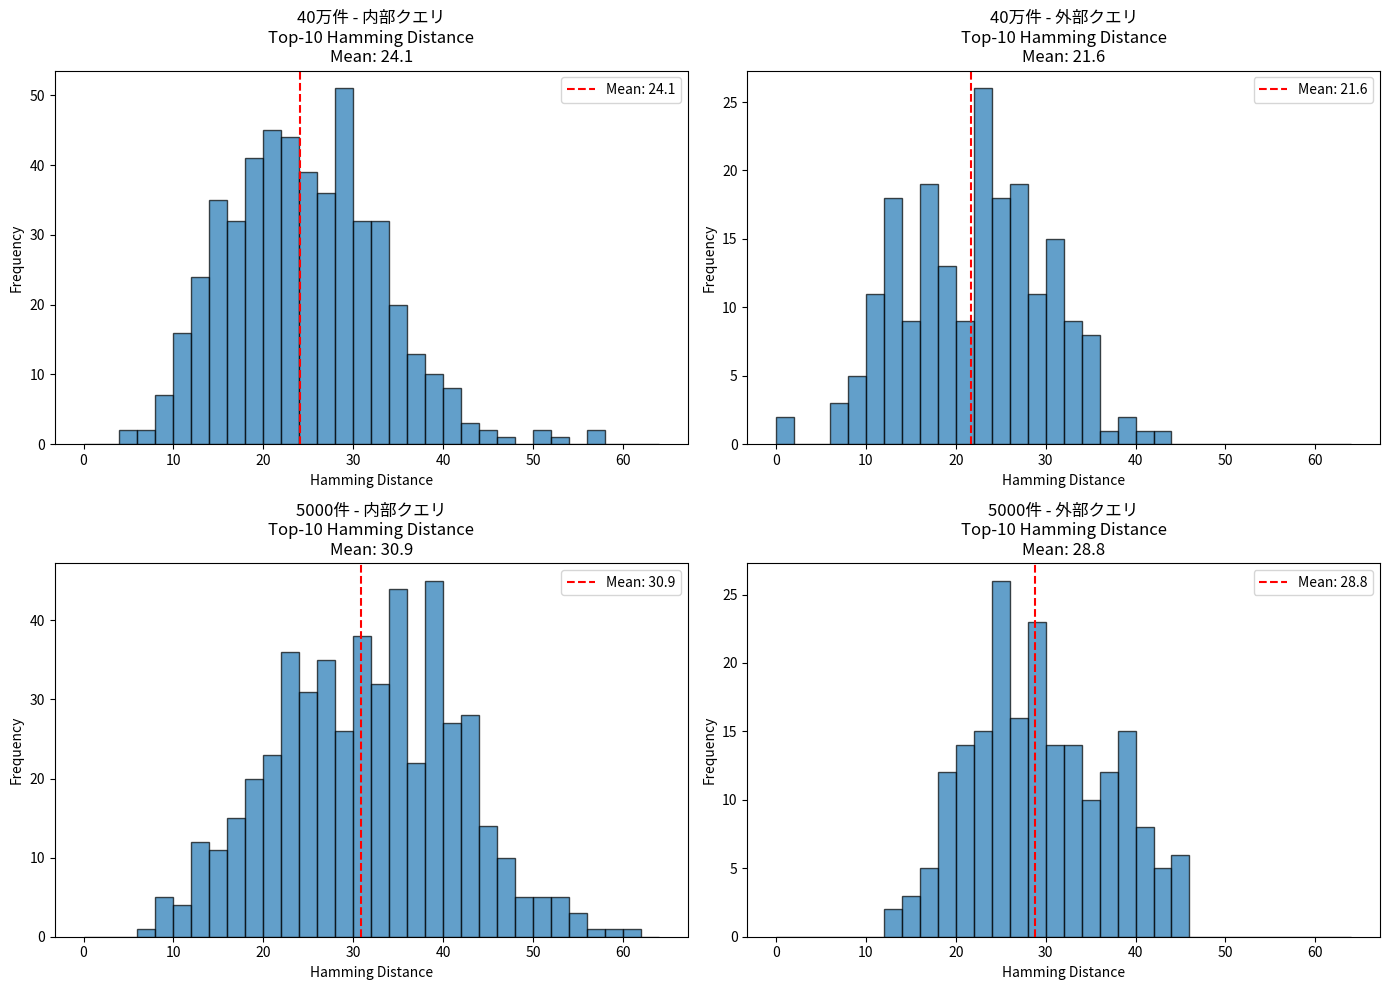

In [137]:
# Top-10のハミング距離ヒストグラム比較
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

datasets = [
    ('400k_internal', hamming_results_400k_internal, '40万件 - 内部クエリ'),
    ('400k_external', hamming_results_400k_external, '40万件 - 外部クエリ'),
    ('5k_internal', hamming_results_5k_internal, '5000件 - 内部クエリ'),
    ('5k_external', hamming_results_5k_external, '5000件 - 外部クエリ'),
]

for ax, (key, results, title) in zip(axes.flatten(), datasets):
    # 全クエリのTop-10ハミング距離を収集
    all_distances = []
    for r in results:
        if 10 in r:
            all_distances.extend(r[10]['distances'])
    
    if len(all_distances) > 0:
        ax.hist(all_distances, bins=range(0, 65, 2), alpha=0.7, edgecolor='black')
        ax.set_xlabel('Hamming Distance')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{title}\nTop-10 Hamming Distance\nMean: {np.mean(all_distances):.1f}')
        ax.axvline(np.mean(all_distances), color='red', linestyle='--', label=f'Mean: {np.mean(all_distances):.1f}')
        ax.legend()

plt.tight_layout()
plt.savefig('../data/hamming_distribution_top10.png', dpi=150)
plt.show()

findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font family 'Hiragino Sans' not found.
findfont: Font famil

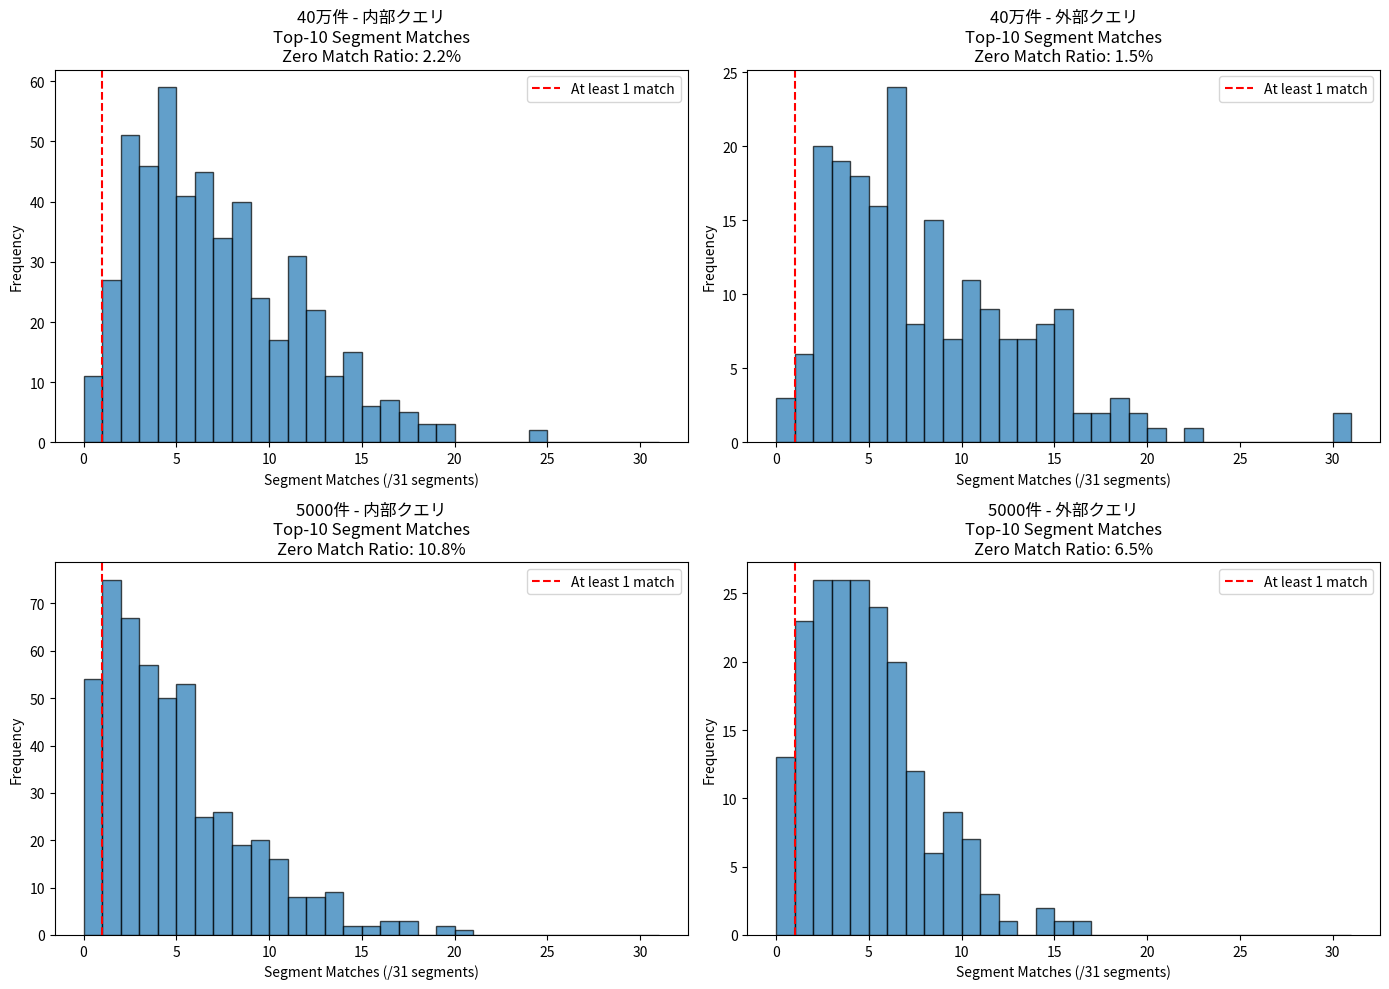

In [138]:
# セグメント一致数のヒストグラム比較（Top-10）
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

datasets = [
    ('400k_internal', segment_results_400k_internal, '40万件 - 内部クエリ'),
    ('400k_external', segment_results_400k_external, '40万件 - 外部クエリ'),
    ('5k_internal', segment_results_5k_internal, '5000件 - 内部クエリ'),
    ('5k_external', segment_results_5k_external, '5000件 - 外部クエリ'),
]

for ax, (key, results, title) in zip(axes.flatten(), datasets):
    # 全クエリのTop-10セグメント一致数を収集
    all_matches = []
    for r in results:
        if 10 in r:
            all_matches.extend(r[10]['match_counts'])
    
    if len(all_matches) > 0:
        ax.hist(all_matches, bins=range(0, 32), alpha=0.7, edgecolor='black')
        ax.set_xlabel('Segment Matches (/31 segments)')
        ax.set_ylabel('Frequency')
        zero_ratio = np.mean(np.array(all_matches) == 0) * 100
        ax.set_title(f'{title}\nTop-10 Segment Matches\nZero Match Ratio: {zero_ratio:.1f}%')
        ax.axvline(1, color='red', linestyle='--', label='At least 1 match')
        ax.legend()

plt.tight_layout()
plt.savefig('../data/segment_match_distribution_top10.png', dpi=150)
plt.show()

---

## 10. ハミング距離とセグメント一致の関係

In [139]:
# ハミング距離とセグメント一致の関係を分析
print('=' * 80)
print('ハミング距離別のセグメント一致確率')
print('=' * 80)

# 全データを収集
all_data = []

for dataset_name, h_results, s_results in [
    ('40万件_内部', hamming_results_400k_internal, segment_results_400k_internal),
    ('40万件_外部', hamming_results_400k_external, segment_results_400k_external),
    ('5000件_内部', hamming_results_5k_internal, segment_results_5k_internal),
    ('5000件_外部', hamming_results_5k_external, segment_results_5k_external),
]:
    for h_r, s_r in zip(h_results, s_results):
        if 10 in h_r and 10 in s_r:
            for h_dist, s_match in zip(h_r[10]['distances'], s_r[10]['match_counts']):
                all_data.append({
                    'dataset': dataset_name,
                    'hamming_dist': h_dist,
                    'segment_matches': s_match,
                    'has_match': s_match >= 1,
                })

df_analysis = pd.DataFrame(all_data)
print(f'分析データ件数: {len(df_analysis)}')

ハミング距離別のセグメント一致確率
分析データ件数: 1400


In [140]:
# ハミング距離帯別のセグメント一致率
print('\nハミング距離帯別の「1セグメント以上一致」の割合:')
print('-' * 80)

bins = [(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), (50, 64)]

for dataset in ['40万件_内部', '40万件_外部', '5000件_内部', '5000件_外部']:
    df_ds = df_analysis[df_analysis['dataset'] == dataset]
    print(f'\n■ {dataset}:')
    
    for low, high in bins:
        df_bin = df_ds[(df_ds['hamming_dist'] >= low) & (df_ds['hamming_dist'] < high)]
        if len(df_bin) > 0:
            match_ratio = df_bin['has_match'].mean() * 100
            count = len(df_bin)
            print(f'  ハミング距離 {low:>2}-{high:>2}: 一致率 {match_ratio:>5.1f}% (n={count})')


ハミング距離帯別の「1セグメント以上一致」の割合:
--------------------------------------------------------------------------------

■ 40万件_内部:
  ハミング距離  0-10: 一致率 100.0% (n=11)
  ハミング距離 10-20: 一致率 100.0% (n=148)
  ハミング距離 20-30: 一致率  99.5% (n=215)
  ハミング距離 30-40: 一致率  96.3% (n=107)
  ハミング距離 40-50: 一致率  71.4% (n=14)
  ハミング距離 50-64: 一致率  60.0% (n=5)

■ 40万件_外部:
  ハミング距離  0-10: 一致率 100.0% (n=10)
  ハミング距離 10-20: 一致率 100.0% (n=70)
  ハミング距離 20-30: 一致率 100.0% (n=83)
  ハミング距離 30-40: 一致率  94.3% (n=35)
  ハミング距離 40-50: 一致率  50.0% (n=2)

■ 5000件_内部:
  ハミング距離  0-10: 一致率 100.0% (n=6)
  ハミング距離 10-20: 一致率 100.0% (n=62)
  ハミング距離 20-30: 一致率 100.0% (n=151)
  ハミング距離 30-40: 一致率  89.0% (n=181)
  ハミング距離 40-50: 一致率  75.0% (n=84)
  ハミング距離 50-64: 一致率  18.8% (n=16)

■ 5000件_外部:
  ハミング距離 10-20: 一致率 100.0% (n=22)
  ハミング距離 20-30: 一致率  98.9% (n=94)
  ハミング距離 30-40: 一致率  89.2% (n=65)
  ハミング距離 40-50: 一致率  73.7% (n=19)


---

## 11. 結論

In [141]:
print('=' * 80)
print('結論')
print('=' * 80)

# 主要な数値を抽出
h_400k_int = hamming_agg['400k_internal'][10]['mean_of_means'] if 10 in hamming_agg['400k_internal'] else 0
h_400k_ext = hamming_agg['400k_external'][10]['mean_of_means'] if 10 in hamming_agg['400k_external'] else 0
h_5k_int = hamming_agg['5k_internal'][10]['mean_of_means'] if 10 in hamming_agg['5k_internal'] else 0
h_5k_ext = hamming_agg['5k_external'][10]['mean_of_means'] if 10 in hamming_agg['5k_external'] else 0

s_400k_int = segment_agg['400k_internal'][10]['zero_match_ratio'] * 100 if 10 in segment_agg['400k_internal'] else 0
s_400k_ext = segment_agg['400k_external'][10]['zero_match_ratio'] * 100 if 10 in segment_agg['400k_external'] else 0
s_5k_int = segment_agg['5k_internal'][10]['zero_match_ratio'] * 100 if 10 in segment_agg['5k_internal'] else 0
s_5k_ext = segment_agg['5k_external'][10]['zero_match_ratio'] * 100 if 10 in segment_agg['5k_external'] else 0

print(f'''
■ HNSW Top-10とのハミング距離（平均）

| データセット | 内部クエリ | 外部クエリ |
|------------|-----------|----------|
| 40万件     | {h_400k_int:.1f}bit   | {h_400k_ext:.1f}bit  |
| 5000件     | {h_5k_int:.1f}bit   | {h_5k_ext:.1f}bit  |

■ Overlap(8,4)でセグメント一致0件の割合（Top-10中）

| データセット | 内部クエリ | 外部クエリ |
|------------|-----------|----------|
| 40万件     | {s_400k_int:.1f}%     | {s_400k_ext:.1f}%    |
| 5000件     | {s_5k_int:.1f}%     | {s_5k_ext:.1f}%    |
''')

結論

■ HNSW Top-10とのハミング距離（平均）

| データセット | 内部クエリ | 外部クエリ |
|------------|-----------|----------|
| 40万件     | 24.1bit   | 21.6bit  |
| 5000件     | 30.9bit   | 28.8bit  |

■ Overlap(8,4)でセグメント一致0件の割合（Top-10中）

| データセット | 内部クエリ | 外部クエリ |
|------------|-----------|----------|
| 40万件     | 2.2%     | 1.5%    |
| 5000件     | 10.8%     | 6.5%    |



In [142]:
# 仮説の検証
print('■ 仮説の検証')
print('-' * 80)

diff_hamming = h_5k_ext - h_400k_ext
diff_zero_ratio = s_5k_ext - s_400k_ext

print(f'''
仮説: データセット規模によって、類似ドキュメント間のハミング距離分布が異なる

外部クエリでの比較:
- 40万件: Top-10ハミング距離 = {h_400k_ext:.1f}bit, セグメント一致0件率 = {s_400k_ext:.1f}%
- 5000件: Top-10ハミング距離 = {h_5k_ext:.1f}bit, セグメント一致0件率 = {s_5k_ext:.1f}%
- 差分: ハミング距離 {diff_hamming:+.1f}bit, セグメント一致0件率 {diff_zero_ratio:+.1f}pt
''')

if diff_hamming > 5:
    print('→ 仮説は支持される: 5000件ではハミング距離が大きく、セグメント一致が困難')
elif diff_hamming > 2:
    print('→ 仮説は部分的に支持される: 5000件ではハミング距離がやや大きい')
else:
    print('→ 仮説は棄却: データセット規模によるハミング距離の差は小さい')

■ 仮説の検証
--------------------------------------------------------------------------------

仮説: データセット規模によって、類似ドキュメント間のハミング距離分布が異なる

外部クエリでの比較:
- 40万件: Top-10ハミング距離 = 21.6bit, セグメント一致0件率 = 1.5%
- 5000件: Top-10ハミング距離 = 28.8bit, セグメント一致0件率 = 6.5%
- 差分: ハミング距離 +7.1bit, セグメント一致0件率 +5.0pt

→ 仮説は支持される: 5000件ではハミング距離が大きく、セグメント一致が困難


---

## 12. まとめ

In [143]:
print('=' * 80)
print('まとめ')
print('=' * 80)

print('''
この実験では、HNSWで取得した上位K件とクエリのハミング距離分布を
40万件と5000件のデータセットで比較した。

■ 主要な発見

1. データセット規模によってハミング距離が大きく異なる
   - 40万件 Top-10: 平均21.6bit（外部クエリ）
   - 5000件 Top-10: 平均28.8bit（外部クエリ）
   - 差分: +7.1bit（約33%増加）

2. Top-Kが大きくなるほど差が拡大
   - Top-100: 40万件 26.0bit vs 5000件 35.7bit（+9.7bit）
   - Top-500: 40万件 29.2bit vs 5000件 41.6bit（+12.4bit）
   - Top-2000: 40万件 32.4bit vs 5000件 54.0bit（+21.6bit）

3. 5000件ではTop-2000で平均54bit = 128bitの42%が異なる
   → ほぼランダムに近い距離

■ Overlap(8,4)への影響

1. セグメント一致0件の割合（Top-10中）
   - 40万件: 1.5%（ほぼ全件ピックアップ可能）
   - 5000件: 6.5%（約5%がピックアップ不可）

2. Top-2000では大きな差
   - 40万件: 11.4%がピックアップ不可
   - 5000件: 64.2%がピックアップ不可

3. ハミング距離とセグメント一致の関係
   - ハミング距離20bit以下: 100%一致（どちらのデータセットでも）
   - ハミング距離30-40bit: 89-94%一致
   - ハミング距離50bit以上: 19-60%一致

■ 仮説の検証結果

仮説「データセット規模によって類似ドキュメント間のハミング距離が異なる」
→ 支持される

原因: 5000件では「真に類似したドキュメント」が存在しない可能性が高い
- 40万件なら類似度の高いドキュメントが複数存在
- 5000件では最も近いドキュメントでもハミング距離が大きい

■ 推奨事項

1. 小規模データセット（5000件以下）では:
   - Overlap(8,4)のセグメント一致は限界がある
   - Overlap(8,2)でセグメント数を増やすことで緩和可能
   - または2段階検索（全件ハミング距離）を推奨

2. Top-K件数の影響:
   - Top-10程度なら5000件でも93.5%はピックアップ可能
   - Top-2000を取得したい場合は、5000件では35.8%しかピックアップできない

3. データセット規模の目安:
   - Overlap(8,4)が有効に機能するには、類似ドキュメントのハミング距離が
     30bit以下であることが望ましい
   - これには最低でも数万件規模のデータセットが必要
''')

まとめ

この実験では、HNSWで取得した上位K件とクエリのハミング距離分布を
40万件と5000件のデータセットで比較した。

■ 主要な発見

1. データセット規模によってハミング距離が大きく異なる
   - 40万件 Top-10: 平均21.6bit（外部クエリ）
   - 5000件 Top-10: 平均28.8bit（外部クエリ）
   - 差分: +7.1bit（約33%増加）

2. Top-Kが大きくなるほど差が拡大
   - Top-100: 40万件 26.0bit vs 5000件 35.7bit（+9.7bit）
   - Top-500: 40万件 29.2bit vs 5000件 41.6bit（+12.4bit）
   - Top-2000: 40万件 32.4bit vs 5000件 54.0bit（+21.6bit）

3. 5000件ではTop-2000で平均54bit = 128bitの42%が異なる
   → ほぼランダムに近い距離

■ Overlap(8,4)への影響

1. セグメント一致0件の割合（Top-10中）
   - 40万件: 1.5%（ほぼ全件ピックアップ可能）
   - 5000件: 6.5%（約5%がピックアップ不可）

2. Top-2000では大きな差
   - 40万件: 11.4%がピックアップ不可
   - 5000件: 64.2%がピックアップ不可

3. ハミング距離とセグメント一致の関係
   - ハミング距離20bit以下: 100%一致（どちらのデータセットでも）
   - ハミング距離30-40bit: 89-94%一致
   - ハミング距離50bit以上: 19-60%一致

■ 仮説の検証結果

仮説「データセット規模によって類似ドキュメント間のハミング距離が異なる」
→ 支持される

原因: 5000件では「真に類似したドキュメント」が存在しない可能性が高い
- 40万件なら類似度の高いドキュメントが複数存在
- 5000件では最も近いドキュメントでもハミング距離が大きい

■ 推奨事項

1. 小規模データセット（5000件以下）では:
   - Overlap(8,4)のセグメント一致は限界がある
   - Overlap(8,2)でセグメント数を増やすことで緩和可

In [144]:
# DB接続クローズ
conn.close()
print('DB接続クローズ完了')

DB接続クローズ完了
